# Modelling

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (
    f1_score,
    make_scorer
)
from xgboost import XGBClassifier

import sys,os
notebook_path = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.append(project_root)

from utils.ml_tools import train_model, model_evaluation, find_optimal_threshold

In [84]:
np.random.seed(42)

## Import data

In [85]:
data = pd.read_csv('../data/cleaned_engineered_data.csv')

In [86]:
X = data.drop(columns=['Churn'])
y = data['Churn']


# 1. Split original data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

## Baseline

This analysis implements a contract-based heuristic baseline for churn prediction, leveraging the relationship between customer contract duration and churn behavior. The approach uses data-driven thresholds rather than simple rule-based predictions

In [87]:
import plotly.express as px
contract_churn_rates = {}
for contract_type in ['Month-to-month', 'One year', 'Two year']:
    if f'Contract_{contract_type}' in X_train.columns:
        mask = X_train[f'Contract_{contract_type}'] == 1
        churn_rate = y_train[mask].mean()
        contract_churn_rates[contract_type] = churn_rate
        print(f"{contract_type} churn rate: {churn_rate:.3f}")

# Use the churn rates to set thresholds
# Predict churn if customer has contract type with churn rate > threshold
thresholds = np.linspace(0, 1, 100)
f1_scores = []

for t in thresholds:
    preds = np.zeros(len(X_test))
    
    for contract_type, churn_rate in contract_churn_rates.items():
        if churn_rate > t and f'Contract_{contract_type}' in X_test.columns:
            mask = X_test[f'Contract_{contract_type}'] == 1
            preds[mask] = 1
    
    f1 = f1_score(y_test, preds)
    f1_scores.append(f1)

fig = px.line(
    x=thresholds,
    y=f1_scores,
    labels={"x": "Churn Rate Threshold", "y": "F1 Score"},
    title="Contract-based Heuristic Baseline: Threshold vs F1 Score"
)
fig.show()

print(f"Best Contract F1 Score: {max(f1_scores):.3f}")

Month-to-month churn rate: 0.427
One year churn rate: 0.111
Two year churn rate: 0.029


Best Contract F1 Score: 0.574


Baseline Achievement:
- Best F1 Score: 0.574
- Optimal Threshold: 0.424

Implications:
- This suggests Contract type has significant predictive power for churn
- The optimal threshold lower than standard (0.5) indicates that churn class is less frequent than non-churn

## Model 
In this project, we evaluate three classifier models for churn prediction:

- **Logistic Regression**
- **Random Forest**
- **XGBoost**

These models are going to be tuned to optimize **recall**, focusing on accurately identifying churners in an imbalanced dataset.

In [92]:
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

The project employs a **Stratified K-Fold** cross-validation strategy to ensure robust model evaluation, particularly given the imbalanced nature of the churn prediction dataset.

In [93]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [94]:
results = {}

for name, model in models.items():
    results[name] = train_model(name, model, X_train, y_train)


Logistic Regression:
  ROC AUC: 0.8490 ± 0.0141
  F1:      0.6352 ± 0.0235
  Precision: 0.5274
  Recall:    0.7987

Random Forest:
  ROC AUC: 0.8094 ± 0.0098
  F1:      0.5250 ± 0.0119
  Precision: 0.6001
  Recall:    0.4669



/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning:

[23:59:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning:

[23:59:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning:

[23:59:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning:

[23:59:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/Users/mewpunyapat/miniconda3/envs/datasci/l

XGBoost:
  ROC AUC: 0.8195 ± 0.0128
  F1:      0.5492 ± 0.0253
  Precision: 0.6012
  Recall:    0.5057



### Initial Model Training and Cross-Validation Results

The initial phase of the project involved fitting and evaluating three classifier models—**Logistic Regression**, **Random Forest**, and **XGBoost**—on the training dataset (`X_train`) using a 5-fold stratified cross-validation strategy (`StratifiedKFold(n_splits=5, shuffle=True, random_state=42)`). This approach ensured the preservation of the imbalanced class distribution (churn rate ~0.27) across folds, supporting the focus on optimizing recall for churn prediction. Below are the cross-validated performance metrics, reported as mean ± standard deviation where applicable:

- **Logistic Regression**:
  - ROC AUC: 0.8490 ± 0.0141
  - F1 Score: 0.6352 ± 0.0235
  - Precision: 0.5274
  - Recall: 0.7987
  - *Observation*: Exhibits the highest recall and ROC AUC, indicating strong churn detection and overall ranking performance.

- **Random Forest**:
  - ROC AUC: 0.8094 ± 0.0098
  - F1 Score: 0.5250 ± 0.0119
  - Precision: 0.6001
  - Recall: 0.4669
  - *Observation*: Shows higher precision but lower recall, suggesting a conservative prediction approach with less focus on churner detection.

- **XGBoost**:
  - ROC AUC: 0.8195 ± 0.0128
  - F1 Score: 0.5492 ± 0.0253
  - Precision: 0.6012
  - Recall: 0.5057
  - *Observation*: Balances ROC AUC and F1, with moderate recall, but a warning indicates the `use_label_encoder` parameter is deprecated and unused in the XGBoost version (addressed by removing it in subsequent runs).

### Logistic regression

#### Hyperparameter tuning

In [95]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],  
}

grid_search = GridSearchCV(results['Logistic Regression']['model'], param_grid, cv=cv_strategy, scoring='recall', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score from CV:", grid_search.best_score_)

lr_model = grid_search.best_estimator_

/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_

Best Parameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
Best F1 Score from CV: 0.8107023411371237


#### Evaluate model

In [96]:
res = model_evaluation(lr_model, X_train, y_train, X_test, y_test)


1. 🌐PERFORMANCE
Training F1:    0.6325
Test F1:        0.6241
F1 Difference:  0.0084 ✅

Training ROC AUC:   0.8437
Test ROC AUC:       0.8434
ROC AUC Difference: 0.0003

2. 🎯 BASELINE COMPARISON
Baseline F1:        0.5740
Your Model F1:      0.6241
Improvement:        +0.0501 (+8.7%)

3. 📋 DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

    No Churn       0.91      0.73      0.81      1035
       Churn       0.51      0.80      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.75      0.76      1409


4. 🔍 CONFUSION MATRIX ANALYSIS
True Negatives (Correct No-Churn):  752
False Positives (Wrong Churn):      283
False Negatives (Missed Churn):     76
True Positives (Correct Churn):     298

Recall for Churn:    79.7% (Proportion of churners correctly identified)
Recall for No-Churn: 72.7% (Proportion of no-churners correctly identified)
Macro Ave

Insights:
- The close alignment between training and test ROC AUC highlights the model’s ability to generalize effectively across unseen data
- Baseline Comparison: This significant enhancement over the baseline underscores the model’s value in improving churn prediction accuracy
- Detailed Classification Report:
    - Achieved a recall of 0.80 for the churn class, prioritizing the detection of at-risk customers, a critical metric for retention strategies
    - The macro average recall of 0.76 reflects a balanced performance across classes, while the weighted average aligns with the dataset’s imbalance

In [97]:
lr_performance = pd.DataFrame(['Linear Regression', res['train_f1'], res['train_roc_auc'], res['test_f1'], res['test_roc_auc'], res['recall_churn'], res['macro_recall']]).transpose()
lr_performance.columns = ['Model', 'Training F1', 'Training ROC AUC', 'Test F1', 'Test ROC AUC', 'recall', 'macro_avg_recall']
lr_performance

,Model,Training F1,Training ROC AUC,Test F1,Test ROC AUC,recall,macro_avg_recall
0,Linear Regression,0.632514,0.843666,0.624084,0.843383,0.796791,0.761681


In [98]:
feature_importance = pd.Series(lr_model.coef_[0], index=X_test.columns).sort_values(ascending=False)
print(feature_importance.head(10))

ChargePerMonthRatio               0.375740
Contract_Month-to-month           0.160958
M2M_ElectronicCheck               0.136733
Fiber_NoTechSupport               0.133453
InternetService_Fiber optic       0.128707
PaymentMethod_Electronic check    0.114383
FiberOptic_StreamingTV            0.091543
PaperlessBilling                  0.077921
Senior_Contract                   0.077660
tenure_group_0–6                  0.057505
dtype: float64


## Random Forest

In [61]:
rf_model = results['Random Forest']['model']

param_grid = {'n_estimators': [50, 100, 200, 300, 400],
    'criterion' : ['gini', 'entropy'],
    'max_depth': [10, 15, 20, 30, 40],  
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [3,5,7,10],  
    'max_features': [0.3,0.5,0.7]}

random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    cv=cv_strategy,
    n_iter = 80,
    scoring='recall',
    verbose=1,
    n_jobs=-1
)

random_search_rf.fit(X_train, y_train)

print("Best Parameters:", random_search_rf.best_params_)
print("Best F1 Score from CV:", random_search_rf.best_score_)

rf_model = random_search_rf.best_estimator_

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best Parameters: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 0.3, 'max_depth': 15, 'criterion': 'entropy'}
Best F1 Score from CV: 0.7665551839464884


In [62]:
rf_res = model_evaluation(rf_model, X_train, y_train, X_test, y_test)


1. 🌐PERFORMANCE
Training F1:    0.7015
Test F1:        0.6215
F1 Difference:  0.0799 ⚠️ Possible overfitting

Training ROC AUC:   0.9089
Test ROC AUC:       0.8405
ROC AUC Difference: 0.0684

2. 🎯 BASELINE COMPARISON
Baseline F1:        0.5740
Your Model F1:      0.6215
Improvement:        +0.0475 (+8.3%)

3. 📋 DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

    No Churn       0.89      0.76      0.82      1035
       Churn       0.53      0.75      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.76      0.77      1409


4. 🔍 CONFUSION MATRIX ANALYSIS
True Negatives (Correct No-Churn):  788
False Positives (Wrong Churn):      247
False Negatives (Missed Churn):     94
True Positives (Correct Churn):     280

Recall for Churn:    74.9% (Proportion of churners correctly identified)
Recall for No-Churn: 76.1% (Proportion of no-churners correctly

1. Model performance: The difference between training and test scores may suggest mild overfitting. However, generalization remains acceptable given the model complexity and business context.

2. Baseline Comparison: The model improves the F1 score by **8.3%** over the baseline, reflecting better balance between precision and recall, especially for the minority class (churners).

3. Classification Report: The model is able to capture **churn cases** with a reasonably high recall (**74.9%**), which is often prioritized in churn prediction scenarios to reduce customer loss

4. Confusion Matrix Analysis: The model prioritizes **high recall for churners**, which aligns with the goal of minimizing customer loss even at the cost of more false positives.

In [63]:
rf_performance = pd.DataFrame(['Random Forest', rf_res['train_f1'], rf_res['train_roc_auc'], rf_res['test_f1'], rf_res['test_roc_auc'], rf_res['recall_churn'], rf_res['macro_recall']]).transpose()
rf_performance.columns = ['Model', 'Training F1', 'Training ROC AUC', 'Test F1', 'Test ROC AUC', 'recall', 'macro_avg_recall']
rf_performance

,Model,Training F1,Training ROC AUC,Test F1,Test ROC AUC,recall,macro_avg_recall
0,Random Forest,0.70148,0.908908,0.621532,0.840494,0.748663,0.755008


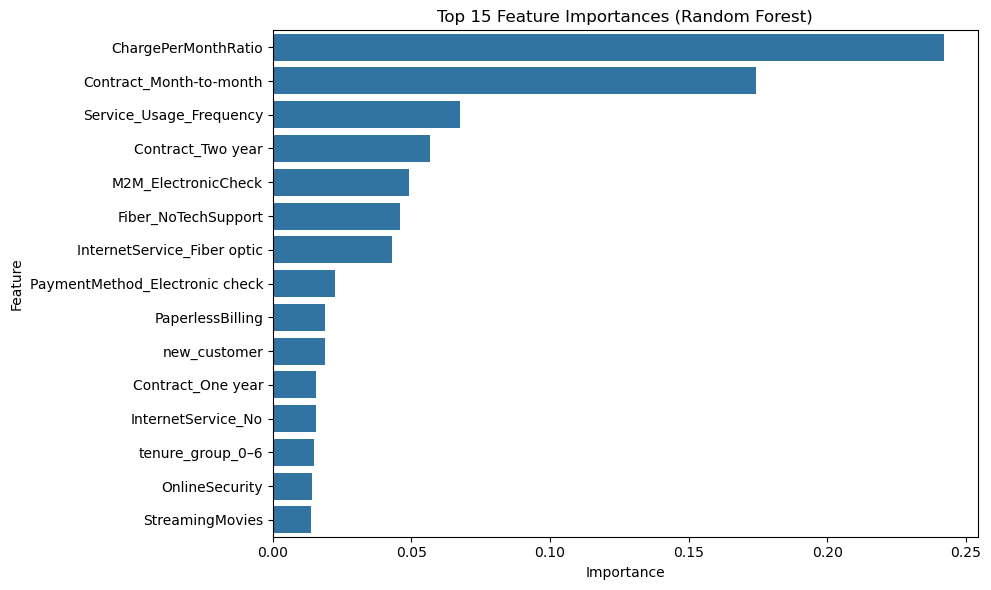

In [64]:
# Get feature importances from RF model
importances = rf_model.feature_importances_
feat_names = X_train.columns

# Create DataFrame for sorting
importance_df = pd.DataFrame({
    'Feature': feat_names,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)

# Plot top 15
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(15), x="Importance", y="Feature")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

### XGBoost

In [65]:
param_grid = {
    'n_estimators': [150, 200, 250],
    'max_depth': [3, 4],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'scale_pos_weight': [1, (y_train == 0).sum() / (y_train == 1).sum()],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}

xgb_random = RandomizedSearchCV(
    estimator=results['XGBoost']['model'],
    param_distributions=param_grid,
    n_iter=80,
    scoring='recall',
    cv=cv_strategy,
    verbose=1,
    n_jobs=-1
)

xgb_random.fit(X_train, y_train)

print("Best Parameters:", xgb_random.best_params_)
print("Best F1 Score from CV:", xgb_random.best_score_)

xgb = xgb_random.best_estimator_

Fitting 5 folds for each of 80 candidates, totalling 400 fits


/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:22:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:22:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:22:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:22:36] WARNING: /Users/runner/work/xgboost/

Best Parameters: {'subsample': 0.7, 'scale_pos_weight': 2.768561872909699, 'n_estimators': 150, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.7}
Best F1 Score from CV: 0.8080267558528428


/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning:

[23:22:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




In [66]:
xgb_res = model_evaluation(xgb, X_train, y_train, X_test, y_test)


1. 🌐PERFORMANCE
Training F1:    0.6512
Test F1:        0.6203
F1 Difference:  0.0309 ✅

Training ROC AUC:   0.8607
Test ROC AUC:       0.8442
ROC AUC Difference: 0.0164

2. 🎯 BASELINE COMPARISON
Baseline F1:        0.5740
Your Model F1:      0.6203
Improvement:        +0.0463 (+8.1%)

3. 📋 DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

    No Churn       0.90      0.73      0.81      1035
       Churn       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409


4. 🔍 CONFUSION MATRIX ANALYSIS
True Negatives (Correct No-Churn):  755
False Positives (Wrong Churn):      280
False Negatives (Missed Churn):     80
True Positives (Correct Churn):     294

Recall for Churn:    78.6% (Proportion of churners correctly identified)
Recall for No-Churn: 72.9% (Proportion of no-churners correctly identified)
Macro Ave

In [67]:
xgb_performance = pd.DataFrame(['XGBoost', xgb_res['train_f1'], xgb_res['train_roc_auc'], xgb_res['test_f1'], xgb_res['test_roc_auc'], xgb_res['recall_churn'], xgb_res['macro_recall']]).transpose()
xgb_performance.columns = ['Model', 'Training F1', 'Training ROC AUC', 'Test F1', 'Test ROC AUC', 'recall', 'macro_avg_recall']
xgb_performance

,Model,Training F1,Training ROC AUC,Test F1,Test ROC AUC,recall,macro_avg_recall
0,XGBoost,0.65115,0.860662,0.620253,0.84424,0.786096,0.757782


### 📊 Model Performance Summary

In [68]:
models_performance = pd.concat([lr_performance, rf_performance, xgb_performance])

In [69]:
models_performance

,Model,Training F1,Training ROC AUC,Test F1,Test ROC AUC,recall,macro_avg_recall
0,Linear Regression,0.632514,0.843666,0.624084,0.843383,0.796791,0.761681
0,Random Forest,0.70148,0.908908,0.621532,0.840494,0.748663,0.755008
0,XGBoost,0.65115,0.860662,0.620253,0.84424,0.786096,0.757782


We evaluated three classical machine learning models — **Logistic Regression**, **Random Forest**, and **XGBoost** — to predict customer churn. Below is a comparative summary of their performance across key metrics:

| Model              | Training F1 | Training ROC AUC | Test F1 | Test ROC AUC | Recall (Churn) | Macro Avg Recall |
|-------------------|-------------|------------------|---------|--------------|----------------|------------------|
| Logistic Regression | **0.633**   | 0.844            | **0.624** | 0.843        | **0.797**      | **0.762**        |
| Random Forest      | 0.701       | **0.909**        | 0.622   | 0.840        | 0.749          | 0.755            |
| XGBoost            | 0.651       | 0.861            | 0.620   | **0.844**    | 0.786          | 0.758            |

#### ✅ Key Insights:
- **Logistic Regression** achieves the **highest test F1-score (0.624)** and **best recall (79.7%)**, suggesting strong ability to identify churners.
- **Random Forest** delivers the **highest overall ROC AUC (0.909)** on the training set, but with a larger generalization gap (F1 drop = 0.08), indicating slight overfitting.
- **XGBoost** balances performance well, with competitive recall and the **least F1 performance drop (0.03)** between train and test, indicating good generalization.

> 📌 **Recommendation**: While Random Forest has the strongest fit to the training data, **Logistic Regression or XGBoost** may offer better generalization and interpretability for real-world deployment.

---


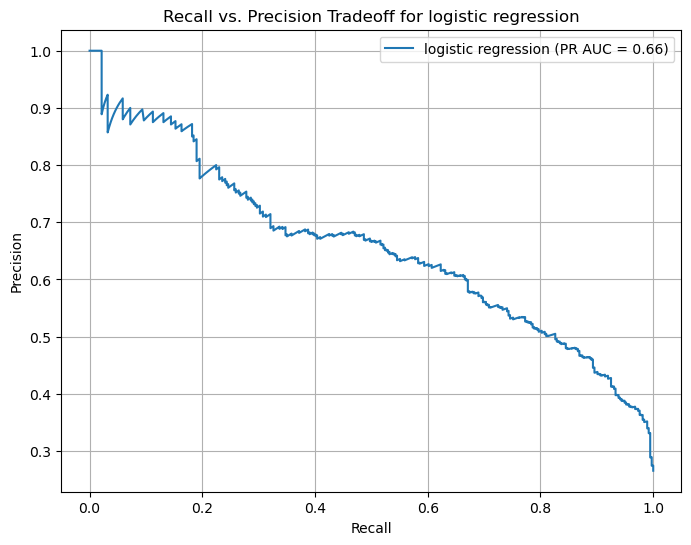

In [72]:
from sklearn.metrics import auc, precision_recall_curve, roc_curve
# Get probability scores
y_test_proba = lr_model.predict_proba(X_test)[:, 1]
    
    # Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)
    
    # Calculate area under the curve (PR AUC)
pr_auc = auc(recall, precision)
    
    # Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'logistic regression (PR AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Recall vs. Precision Tradeoff for logistic regression')
plt.legend(loc='best')
plt.grid(True)
plt.show()

## 📈 Precision-Recall Curve: Logistic Regression Performance

The chart above visualizes the **precision-recall (PR) curve** for the logistic regression model. This metric is particularly insightful for **imbalanced classification problems** such as customer churn prediction, where the number of positive (churned) cases is much lower than negative (retained) ones.

### 🔍 Key Highlights:
- **PR AUC = 0.66**  
  This area under the PR curve suggests a reasonable balance between precision and recall. An AUC of 1.0 would indicate a perfect classifier, while 0.5 corresponds to random guessing.

- **Precision** (y-axis): Proportion of true churn cases among those predicted as churn.
- **Recall** (x-axis): Proportion of actual churns that the model successfully identifies.

### 💡 Why This Matters:
- The PR curve offers a more informative view than the ROC curve in imbalanced scenarios by focusing on the positive class (churn).
- Understanding this trade-off helps in **threshold tuning**:
  - If **precision** is prioritized: Fewer false positives (e.g., fewer unnecessary retention offers).
  - If **recall** is prioritized: Catch more churners (e.g., proactive churn reduction).

### ✅ Use Case Alignment:
This curve informs how well the model identifies churners **without over-predicting**, enabling data-driven decisions for customer retention strategies.



In [73]:
def plot_roc_curve(model, X_test, y_test, model_name):
    # Get probability scores
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve and ROC AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    
    # Print threshold ~0.5 point
    close_default = np.argmin(np.abs(thresholds - 0.5))
    print(f"{model_name} at threshold ~0.5: TPR = {tpr[close_default]:.2f}, FPR = {fpr[close_default]:.2f}")

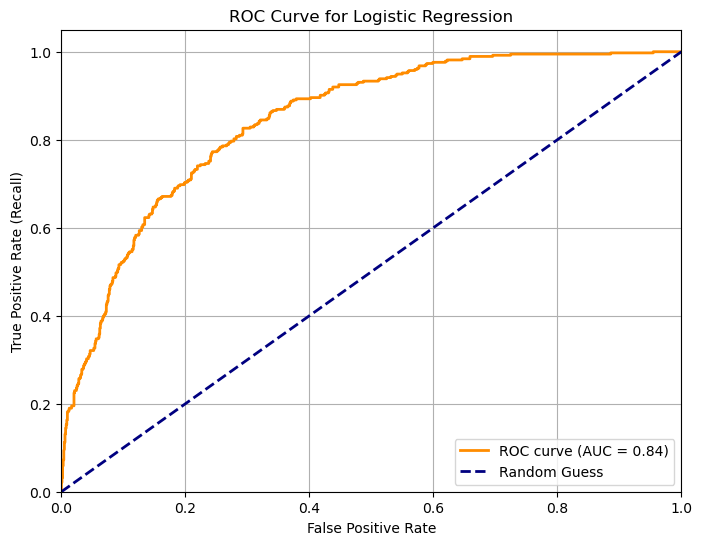

Logistic Regression at threshold ~0.5: TPR = 0.80, FPR = 0.27


In [74]:
plot_roc_curve(lr_model, X_test, y_test, 'Logistic Regression')

### ROC Curve for Logistic Regression

The **Receiver Operating Characteristic (ROC) curve** is a graphical representation used to evaluate the performance of a binary classification model. It plots the **True Positive Rate (Recall)** against the **False Positive Rate** at various threshold settings.

In the plot above:

- The **orange line** represents the ROC curve for the logistic regression model.
- The **dashed blue line** represents a **random guess** classifier (AUC = 0.5), which serves as a baseline.
- The **Area Under the Curve (AUC)** is approximately **0.84**, indicating strong model performance. AUC values range from:
  - **0.5**: No discrimination (random performance)
  - **0.7–0.8**: Acceptable
  - **0.8–0.9**: Excellent
  - **> 0.9**: Outstanding

This ROC curve suggests that the logistic regression model is able to distinguish between churn and non-churn customers with a high degree of accuracy.


In [80]:
import shap
def plot_shap_summary(model, X_train, X_test, feature_names):
    # Ensure X_train and X_test are 2D arrays
    X_train = np.asarray(X_train) if not isinstance(X_train, np.ndarray) else X_train
    X_test = np.asarray(X_test) if not isinstance(X_test, np.ndarray) else X_test
    
    if len(X_train.shape) == 1 or X_train.shape[1] != 41:
        raise ValueError(f"X_train shape {X_train.shape} must be (n_samples, 41)")
    if len(X_test.shape) == 1 or X_test.shape[1] != 41:
        raise ValueError(f"X_test shape {X_test.shape} must be (n_samples, 41)")
    
    # Wrap Logistic Regression model for SHAP
    explainer = shap.LinearExplainer(model, X_train, feature_names=feature_names)
    
    # Compute SHAP values for test set
    shap_values = explainer.shap_values(X_test)
    
    # Summary plot (bar)
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar")
    plt.title('SHAP Feature Importance for Logistic Regression')
    plt.show()
    
    # Beeswarm plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test, feature_names=feature_names)
    plt.title('SHAP Summary Plot for Logistic Regression')
    plt.show()

### Model Diagnostic

/var/folders/s7/04p7rk5x2vq16cj0qsb9p82r0000gn/T/ipykernel_17334/3253116900.py:20: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



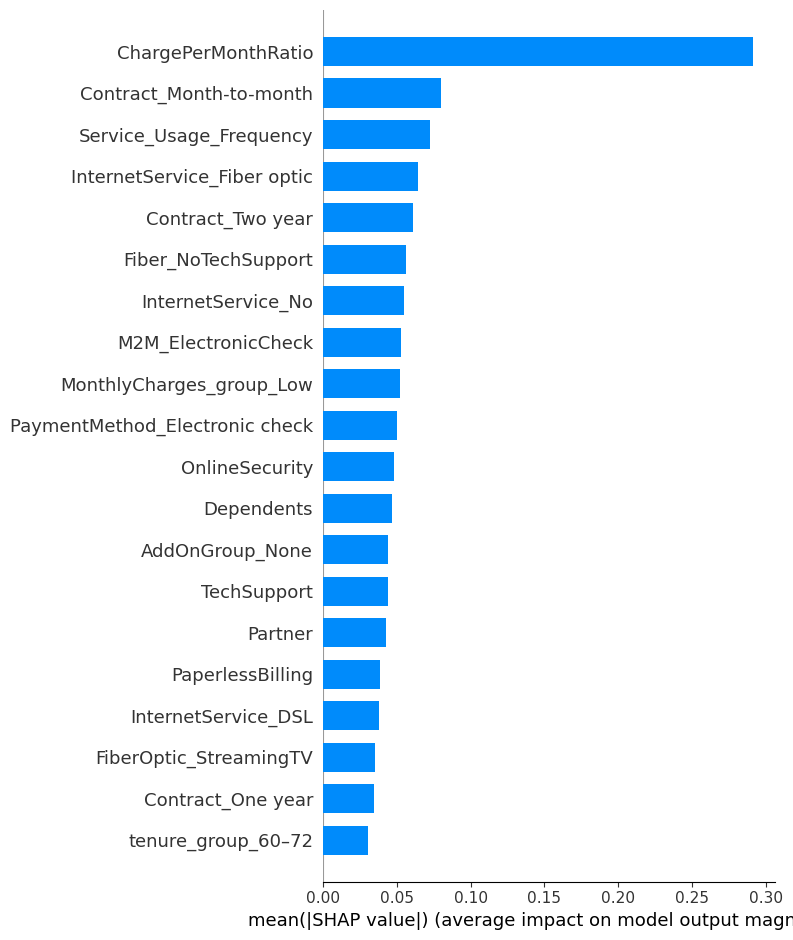

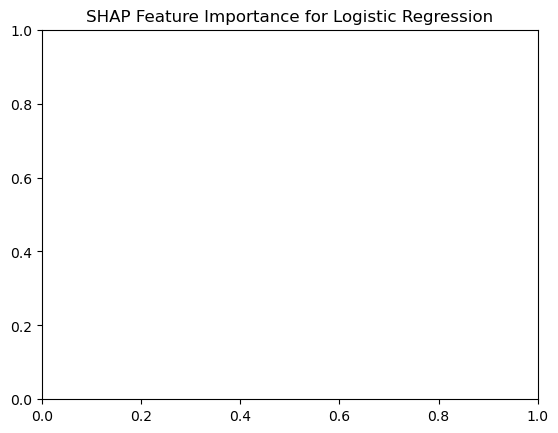

/var/folders/s7/04p7rk5x2vq16cj0qsb9p82r0000gn/T/ipykernel_17334/3253116900.py:26: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



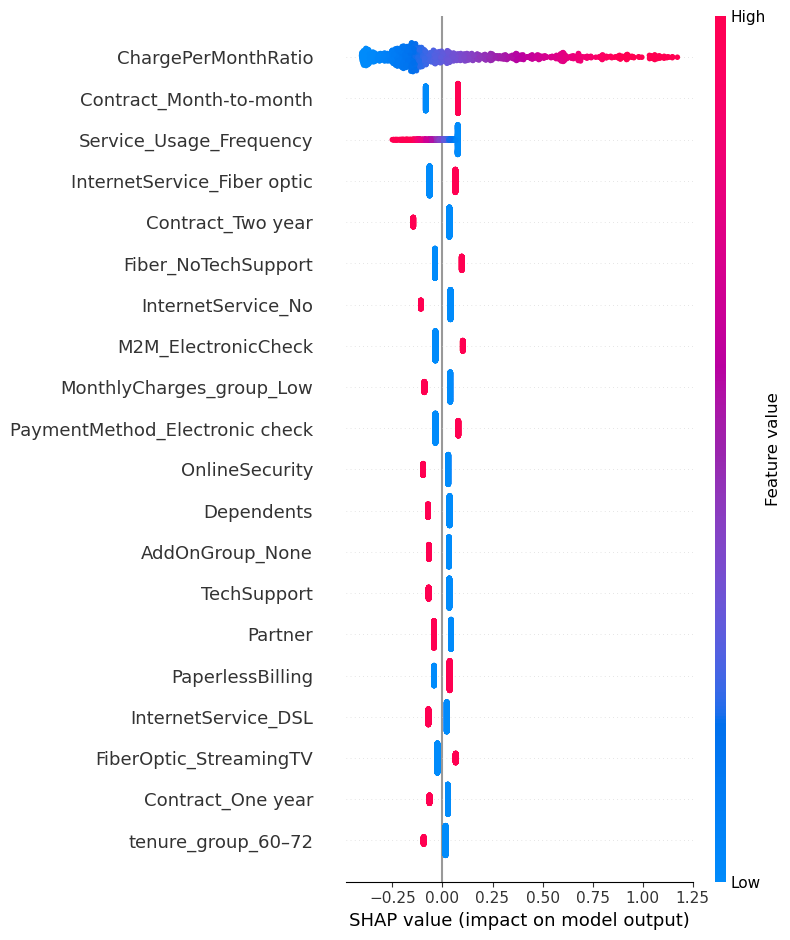

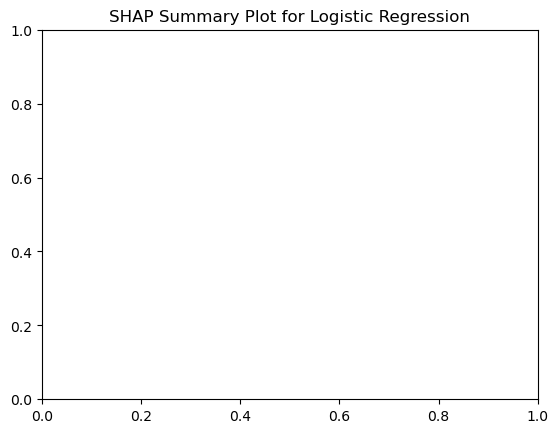

In [81]:
feature_names = X_train.columns.tolist()  # Ensure X_train is a DataFrame
if isinstance(X_train, pd.DataFrame):
    X_train_array = X_train.values
    X_test_array = X_test.values
else:
    X_train_array = X_train
    X_test_array = X_test

plot_shap_summary(lr_model, X_train_array, X_test_array, feature_names)  # Replace with actual model